In [1]:
import numpy as np, prjlib, plottools as pl, healpy as hp, misctools, tools_lens, tools_delens, tools_multitracer, binning as bn
from matplotlib.pyplot import *

In [2]:
snmin, snmax = 1, 100
olmax = 1024
klist = ['comb']

In [3]:
Wsa = prjlib.window('sa')[0]
Wla = prjlib.window('la',ascale=5.)[0] # here, apodized mask is used otherwise the efficiency at edges gets worse
Wsa *= hp.pixelfunc.ud_grade(Wla,512)

SAT mask is further multiplied by hit-count binary


/global/homes/t/toshiyan/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/t/toshiyan/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/t/toshiyan/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [4]:
W2 = np.average(Wsa**2)
print(W2)

0.193311831302735


In [5]:
pid = prjlib.analysis_init(t='id',ntype='cv',snmin=snmin,snmax=snmax)

In [6]:
d = prjlib.data_directory()
dobj = {}
for n in ['base','goal']:
    for ntype in [n,n+'_iso']:
        p = prjlib.analysis_init(t='la',freq='com',fltr='none',snmin=snmin,snmax=snmax,ntype=ntype+'_roll50')
        pE = prjlib.analysis_init(t='co',freq='com',fltr='cinv',ntype=ntype.replace('_iso','')+'_roll50')
        qobj = tools_lens.init_qobj(p.stag,'False',rlmin=300,rlmax=4096)
        mobj = tools_multitracer.mass_tracer(p,qobj,add_cmb=['TT','TE','EE','EB'])
        dobj[ntype] = tools_delens.init_template(p.stag+qobj.ltag,mobj.klist,pE.stag,False,klist=klist,kfltr='none',elmin=50)

In [7]:
mb = bn.multipole_binning(20,lmin=2,lmax=200)
BB, TT, BT = {}, {}, {}
for n in ['base','goal']:
    for ntype in [n,n+'_iso']:
        BB[ntype], TT[ntype], BT[ntype] = 0., 0., 0.
        for i in range(snmin,snmax+1):
            bb, tt, bt = np.loadtxt(dobj[ntype].cl['comb'][i],unpack=True)
            BB[ntype] += bn.binning(bb,mb)/(snmax-snmin+1)
            TT[ntype] += bn.binning(tt,mb)/(snmax-snmin+1)
            BT[ntype] += bn.binning(bt,mb)/(snmax-snmin+1)

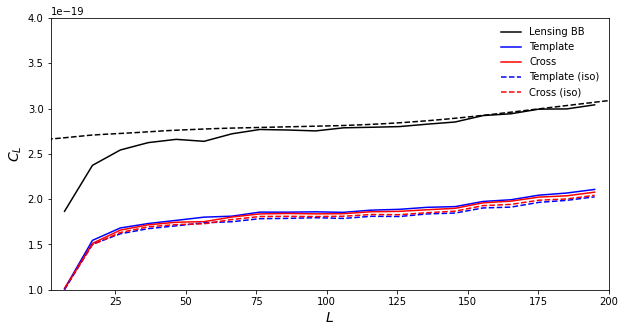

In [10]:
pl.plot_1dstyle(fsize=[10,5],xmin=2,xmax=200,ymin=1e-19,ymax=4e-19)
plot(mb.bc,BB['base']/W2,label='Lensing BB',color='k')
plot(mb.bc,TT['base']/W2,label='Template',color='b',ls='-')
plot(mb.bc,BT['base']/W2,label='Cross',color='r',ls='-')
plot(mb.bc,TT['base_iso']/W2,label='Template (iso)',color='b',ls='--')
plot(mb.bc,BT['base_iso']/W2,label='Cross (iso)',color='r',ls='--')
plot(p.lcl[2,:],'k--')
legend()